In [1]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
%cd gdrive/MyDrive

/content/gdrive/MyDrive


In [3]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# Libraries

import pandas as pd
import time
import numpy as np
import random
import os
from tqdm import tqdm
import itertools
import PIL
import cv2

# Data Analysis
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

#TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array
from tensorflow import keras

# Sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Classes Tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

%matplotlib inline

In [10]:
# Emplacement
path = '/content/gdrive/MyDrive/Projet Radio DST/data/'     

# Accès aux sous-dossiers
dirsi = ["Normal/images/","COVID/images/","Lung_Opacity/images/","Viral Pneumonia/images/"]
dirsm = ["Normal/masks/","COVID/masks/","Lung_Opacity/masks/","Viral Pneumonia/masks/"]
dirsim = ["Normal/masked_images/","COVID/masked_images/","Lung_Opacity/masked_images/","Viral Pneumonia/masked_images/"]

# Images à traiter (brutes ou masquées) et taille échantillon
dirs = dirsi

id_dir = 6
ech_size = 5380

# Classes de 0 à 3 dans la suite
classes = ("Normal","COVID ","Lung_Opacity","Viral Pneumonia") 
nbClasses = len(classes)

In [11]:
# Création des 4 listes de noms d'images

normal_imgs = [fn for fn in os.listdir(path + dirs[0]) if fn.endswith('.png')]
covid_imgs = [fn for fn in os.listdir(path + dirs[1]) if fn.endswith('.png')]
pneumonia_imgs = [fn for fn in os.listdir(path + dirs[2]) if fn.endswith('.png')]
lung_opacity_imgs = [fn for fn in os.listdir(path + dirs[3]) if fn.endswith('.png')]

In [12]:
# Concaténation des emplacements de toutes les images dans une liste unique
liste = []
liste_test = []

test_size = 1000

for fn in normal_imgs[0: (ech_size // nbClasses)] : #Dataframe quilibré sur l'échantillon considéré
    liste.append(path + dirs[0] + fn)
for i in range(test_size):
    liste_test.append(liste[-test_size:][i])
liste = liste[:-test_size]

for fn in covid_imgs[0: (ech_size // nbClasses)] :
    liste.append(path + dirs[1] + fn)
for i in range(test_size):
    liste_test.append(liste[-test_size:][i])
liste = liste[:-test_size]

for fn in pneumonia_imgs[0: (ech_size // nbClasses)] :
    liste.append(path + dirs[2] + fn)
for i in range(test_size):
    liste_test.append(liste[-test_size:][i])
liste = liste[:-test_size]

for fn in lung_opacity_imgs[0: (ech_size // nbClasses)] :
    liste.append(path + dirs[3] + fn)
for i in range(test_size):
    liste_test.append(liste[-test_size:][i])
liste = liste[:-test_size]

# Découpage des noms de chaque emplacement et récupération de la classe (liste de listes)
liste = list(map(lambda x : [x, x.split('/')[id_dir]], liste)) 
liste_test = list(map(lambda x : [x, x.split('/')[id_dir]], liste_test)) 

In [13]:
# Création Dataframe 
df = pd.DataFrame(liste, columns = ['filepath', 'nameLabel'])

# Remplacement des classes sous forme littérale par index
df['label'] = df['nameLabel'].replace(df.nameLabel.unique(), [*range(len(df.nameLabel.unique()))])
df['label'] = df['label'].astype(str)

# Mélange du dataframe
df = df.sample(frac=1, random_state=42)
df = df.reset_index(drop=True)

# Nettoyage variables inutiles
del liste

df = df[0:ech_size]
print(df['nameLabel'].value_counts())
df.head()

COVID              345
Lung_Opacity       345
Viral Pneumonia    345
Normal             345
Name: nameLabel, dtype: int64


,filepath,nameLabel,label
0,/content/gdrive/MyDrive/Projet Radio DST/data/...,COVID,1
1,/content/gdrive/MyDrive/Projet Radio DST/data/...,COVID,1
2,/content/gdrive/MyDrive/Projet Radio DST/data/...,Lung_Opacity,2
3,/content/gdrive/MyDrive/Projet Radio DST/data/...,Viral Pneumonia,3
4,/content/gdrive/MyDrive/Projet Radio DST/data/...,COVID,1


In [14]:
#Création Dataframe TEST 
df_test = pd.DataFrame(liste_test, columns = ['filepath', 'nameLabel'])

# Remplacement des classes sous forme littérale par index
df_test['label'] = df_test['nameLabel'].replace(df_test.nameLabel.unique(), [*range(len(df_test.nameLabel.unique()))])
df_test['label'] = df_test['label'].astype(str)

print(df_test['nameLabel'].value_counts())
df_test.head()

Normal             1000
COVID              1000
Lung_Opacity       1000
Viral Pneumonia    1000
Name: nameLabel, dtype: int64


,filepath,nameLabel,label
0,/content/gdrive/MyDrive/Projet Radio DST/data/...,Normal,0
1,/content/gdrive/MyDrive/Projet Radio DST/data/...,Normal,0
2,/content/gdrive/MyDrive/Projet Radio DST/data/...,Normal,0
3,/content/gdrive/MyDrive/Projet Radio DST/data/...,Normal,0
4,/content/gdrive/MyDrive/Projet Radio DST/data/...,Normal,0


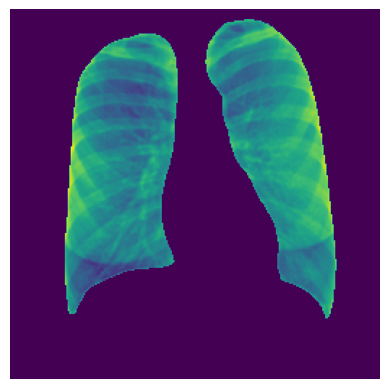

In [ ]:
#Charger Exemple Image
filepath = df.filepath[9]

im = tf.io.read_file(filepath)
im = tf.image.decode_jpeg(im, channels = 1)
plt.imshow(im)
plt.axis('off');

In [ ]:
size = (240, 240)
ratio_val = 0.2 
batch_generator = 32

# Séparation dataframe en ensemble entraiement et validation
train, valid = train_test_split(df, test_size = ratio_val, shuffle = False)

# Création des itérateurs qui chargeront des lots d'images
datagen = ImageDataGenerator( )
test_datagen = ImageDataGenerator( )

print(f"Number of rows in TRAIN total set: {len(df)}")
print(f" - Number of rows in train_set: {len(train)}")
print(f" - Number of rows in valid_set: {len(valid)}")

train_generator = datagen.flow_from_dataframe(dataframe = train,
                                              x_col="filepath",
                                              y_col="label",
                                              class_mode = "sparse",
                                              target_size = size,
                                              batch_size = batch_generator)

valid_generator = datagen.flow_from_dataframe(dataframe = valid,
                                              x_col="filepath",
                                              y_col="label",
                                              class_mode = "sparse",
                                              target_size = size,
                                              batch_size = batch_generator)


Number of rows in TRAIN total set: 1600
 - Number of rows in train_set: 1280
 - Number of rows in valid_set: 320
Found 1280 validated image filenames belonging to 4 classes.
Found 320 validated image filenames belonging to 4 classes.


In [ ]:
print(f"Number of rows in TEST set: {len(df_test)}")

test_generator = test_datagen.flow_from_dataframe(dataframe = df_test,
                                                x_col="filepath",
                                                y_col="label",
                                                class_mode = "sparse",
                                                target_size = size,
                                                batch_size = batch_generator,
                                                shuffle = False) 

X_test = []

for filepath in tqdm(df_test['filepath']) :
    im = tf.io.read_file(filepath)
    im = tf.image.decode_jpeg(im, channels = 1)
    im = tf.image.resize (im, size)
    X_test.append([im])
    
X_test = tf.concat(X_test, axis = 0)

Number of rows in TEST set: 400
Found 400 validated image filenames belonging to 4 classes.


100%|██████████| 400/400 [01:18<00:00,  5.11it/s]


## EfficientNetB1 Model Architecture

In [ ]:
#Définition entrée du modèle
input_model = Input(shape = (240,240,3))

#Chargement et freeze modèle de base Eficient Net
base_model = EfficientNetB1(weights = 'imagenet', include_top=False, input_shape=(240,240,3))
for layer in base_model.layers :
    layer.trainable = False

# Création des différentes couches
global_average = GlobalAveragePooling2D()
dense1 = Dense(units = 1024, activation = "relu")
dropout1 = Dropout(rate=0.2)
dense2 = Dense(units = 512, activation = "relu")
dropout2 = Dropout(rate=0.2)
dense3 = Dense(units = 4, activation = "softmax")

#Application des opérations
x = base_model.output
x = global_average(x)
x = dense1(x)
x = dropout1(x)
x = dense2(x)
x = dropout2(x)
output_model = dense3(x)

#Création du modèle
model = Model(inputs = base_model.input, outputs = output_model)

# Compilation
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "Adam", metrics = ["accuracy"])

#get summary()
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 240, 240, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 240, 240, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                           

In [ ]:
#Callbacks

#define checkpoint
checkpoint = ModelCheckpoint('model.h5', 
                             monitor = 'val_accuracy',
                             save_best_only = True,
                             mode = 'auto',
                             verbose = 1)

#early stopping
#EarlyStopping: a regularization technique, meaning that the model will stop training if it doesn’t see any improvement in 
#val_accuracy in patience = 5 i.e. 5 epochs.'
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 5,
                          mode = 'auto',
                          verbose = 1)

#reduce learning rate
#ReduceLROnPlateau to reduce learning rate when val_accuracy has stopped improving.
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', 
                              factor = 0.3, 
                              patience = 2, 
                              min_delta = 0.001,
                              mode = 'auto',
                              verbose = 1)

## Entrainement Modèle

In [ ]:
# Entrainement du modèle
train_size = train_generator.samples
valid_size = valid_generator.samples

batch_model = 32
epochs = 30

history = model.fit(train_generator,
                    epochs = epochs,
                    steps_per_epoch = train_size // batch_model,
                    validation_data = valid_generator,
                    validation_steps = valid_size // batch_model,
                    verbose = 1,
                    callbacks = [earlystop, reduce_lr])

Epoch 1/30
40/40 [==============================] - 329s 8s/step - loss: 0.8519 - accuracy: 0.6070 - val_loss: 0.6501 - val_accuracy: 0.7125 - lr: 0.0010
Epoch 2/30
40/40 [==============================] - 5s 131ms/step - loss: 0.5699 - accuracy: 0.7633 - val_loss: 0.5317 - val_accuracy: 0.7875 - lr: 0.0010
Epoch 3/30
40/40 [==============================] - 6s 142ms/step - loss: 0.5044 - accuracy: 0.8039 - val_loss: 0.5091 - val_accuracy: 0.8094 - lr: 0.0010
Epoch 4/30
40/40 [==============================] - 6s 150ms/step - loss: 0.4766 - accuracy: 0.7992 - val_loss: 0.4836 - val_accuracy: 0.8062 - lr: 0.0010
Epoch 5/30
40/40 [==============================] - 5s 134ms/step - loss: 0.4465 - accuracy: 0.8164 - val_loss: 0.4812 - val_accuracy: 0.8219 - lr: 0.0010
Epoch 6/30
40/40 [==============================] - 6s 136ms/step - loss: 0.4197 - accuracy: 0.8367 - val_loss: 0.3793 - val_accuracy: 0.8687 - lr: 0.0010
Epoch 7/30
40/40 [==============================] - 5s 131ms/step - los

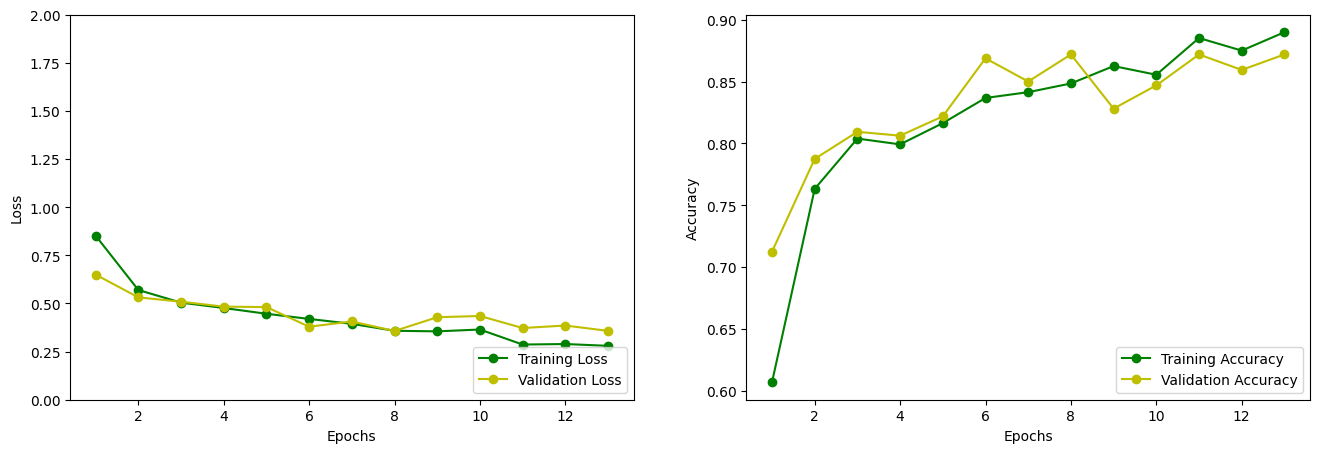

In [ ]:
# Courbes de perte et d'accuracy
plt.figure(figsize = (16,5))

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.subplot(121)
plt.plot(epochs, train_loss, 'g-o', label = 'Training Loss')
plt.plot(epochs, val_loss, 'y-o',  label = 'Validation Loss')
plt.legend(loc = 'lower right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,2)

plt.subplot(122)
plt.plot(epochs, train_acc, 'g-o', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'y-o',  label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show();

## Model Performance

In [ ]:
print('TRAIN accuracy & loss:', model.evaluate(train_generator))
print('\n')
print('TEST accuracy & loss:', model.evaluate(test_generator))

40/40 [==============================] - 4s 103ms/step - loss: 0.1846 - accuracy: 0.9289
TRAIN accuracy & loss: [0.1846068650484085, 0.928906261920929]


13/13 [==============================] - 1s 99ms/step - loss: 0.3841 - accuracy: 0.8675
TEST accuracy & loss: [0.384138822555542, 0.8675000071525574]


In [ ]:
#### Predictions 

In [ ]:
y_test = test_generator.classes
y_test = pd.DataFrame(y_test).astype(int)

y_pred = np.argmax(model.predict(test_generator), axis = 1)

13/13 [==============================] - 4s 112ms/step


In [ ]:
#### Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

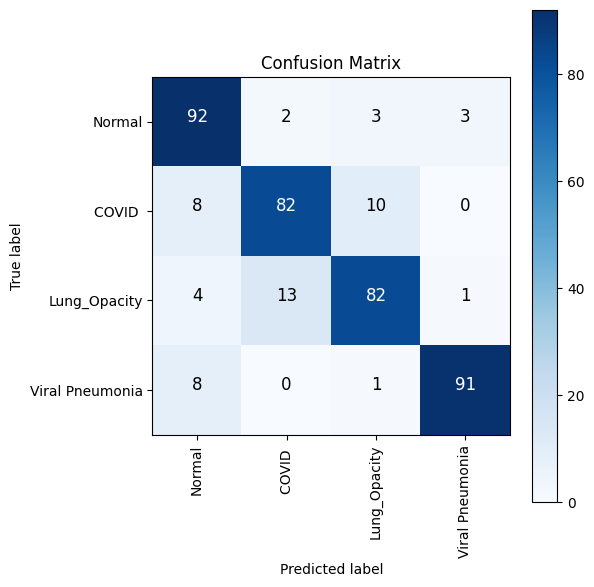

[[92  2  3  3]
 [ 8 82 10  0]
 [ 4 13 82  1]
 [ 8  0  1 91]]


In [ ]:
cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm, classes, normalize = False)
print(cm)

In [ ]:
#### Classification Report

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       100
           1       0.85      0.82      0.83       100
           2       0.85      0.82      0.84       100
           3       0.96      0.91      0.93       100

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400



## Predictions on Test Images 

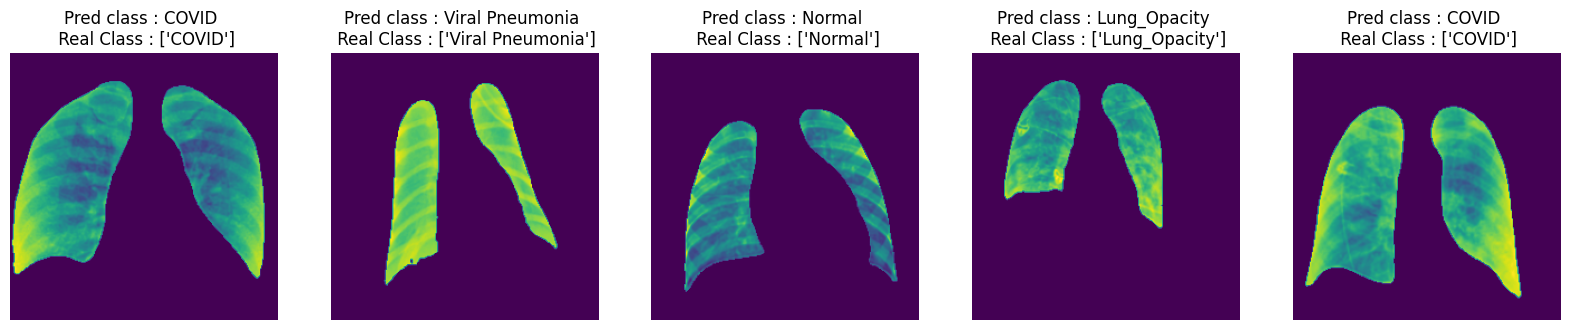

In [ ]:
#Prédiction du modèle

indices_random = tf.random.uniform([5], 0, len(df_test['filepath']), dtype = tf.int32)

plt.figure(figsize = (20,10))

for i, idx in enumerate(indices_random) :
    plt.subplot(1,5,i+1)
    plt.imshow(tf.cast(X_test[idx], tf.int32))
    plt.axis('off')
    plt.title('Pred class : {} \n Real Class : {}'.format(df_test.nameLabel.unique()[y_pred[idx]], df_test.nameLabel.unique()[y_test.values[idx]]))

In [ ]:
model.save_weights("/content/gdrive/MyDrive/Projet Radio DST/model_effnetb1_callbacks_2000img.h5")

##Chargement Model

In [ ]:
model.load_weights("/content/gdrive/MyDrive/Projet Radio DST/model_effnetb1_callbacks_2000img.h5")

GradCAM

In [ ]:
last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, keras.layers.Conv2D))
last_conv_layer.name

'top_conv'

In [ ]:
def VizGradCAM(model, image, interpolant = 0.5, plot_results = True):

    """VizGradCAM - Displays GradCAM based on Keras / TensorFlow models
    using the gradients from the last convolutional layer. This function
    should work with all Keras Application listed here:
    https://keras.io/api/applications/
    Parameters:
    model (keras.model): Compiled Model with Weights Loaded
    image: Image to Perform Inference On
    plot_results (boolean): True - Function Plots using PLT
                            False - Returns Heatmap Array
    Returns:
    Heatmap Array?
    """
    #sanity check
    assert (interpolant > 0 and interpolant < 1), "Heatmap Interpolation Must Be Between 0 - 1"

    #STEP 1: Preprocesss image and make prediction using our model
    #input image
    original_img = np.asarray(image, dtype = np.float32)
    #expamd dimension and get batch size
    img = np.expand_dims(original_img, axis = 0)
    #predict
    prediction = model.predict(img)
    #prediction index
    prediction_idx = np.argmax(prediction)

    #STEP 2: Create new model
    #specify last convolutional layer
    last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, keras.layers.Conv2D))
    target_layer = model.get_layer(last_conv_layer.name)

    #compute gradient of top predicted class
    with tf.GradientTape() as tape:
        #create a model with original model inputs and the last conv_layer as the output
        gradient_model = Model([model.inputs], [target_layer.output, model.output])
        #pass the image through the base model and get the feature map  
        conv2d_out, prediction = gradient_model(img)
        #prediction loss
        loss = prediction[:, prediction_idx]

    #gradient() computes the gradient using operations recorded in context of this tape
    gradients = tape.gradient(loss, conv2d_out)

    #obtain the output from shape [1 x H x W x CHANNEL] -> [H x W x CHANNEL]
    output = conv2d_out[0]

    #obtain depthwise mean
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))


    #create a 7x7 map for aggregation
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)
    #multiply weight for every layer
    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]
    #resize to image size
    activation_map = cv2.resize(activation_map.numpy(), 
                                (original_img.shape[1], 
                                 original_img.shape[0]))
    #ensure no negative number
    activation_map = np.maximum(activation_map, 0)
    #convert class activation map to 0 - 255
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
    #rescale and convert the type to int
    activation_map = np.uint8(255 * activation_map)


    #convert to heatmap
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)

    #superimpose heatmap onto image
    original_img = np.uint8((original_img - original_img.min()) / (original_img.max() - original_img.min()) * 255)
    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    cvt_heatmap = img_to_array(cvt_heatmap)

    #enlarge plot
    plt.rcParams["figure.dpi"] = 100

    if plot_results == True:
        plt.imshow(np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant)))
        plt.axis('off')
    else:
        return cvt_heatmap

1/1 [==============================] - 2s 2s/step


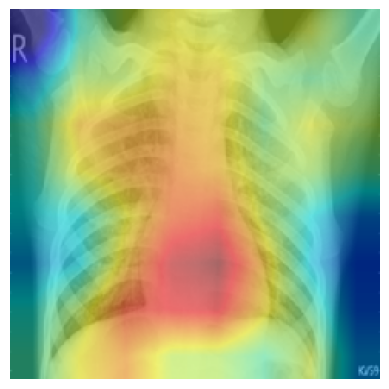

In [ ]:
#load image
img_path = "/content/gdrive/MyDrive/Projet Radio DST/data/Viral Pneumonia/images/Viral Pneumonia-478.png"
test_img = tf.keras.utils.load_img(img_path, target_size = size)

#apply function
VizGradCAM(model, img_to_array(test_img), plot_results=True)